In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_set = pd.read_csv('data/train_preprocessed.csv')
test_set = pd.read_csv('data/test_preprocessed.csv')

In [3]:
train_set.describe()

,label
count,249815.000000
mean,0.180942
std,0.730299
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


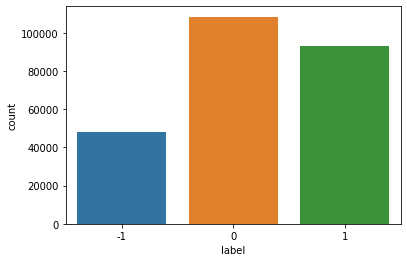

In [4]:
sns.countplot(train_set.label)

In [5]:
train_set['length'] = train_set['text'].apply(lambda x: len(str(x)))
train_set['words_count'] = train_set['text'].apply(lambda x: len(str(x).split()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f275323eb00>,
      dtype=object)

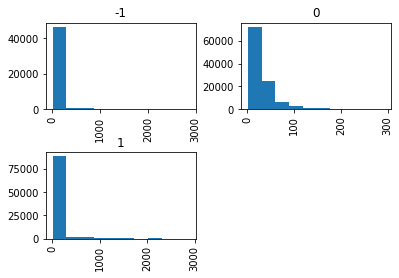

In [5]:
train_set.hist(column="length", by="label")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f275323ecf8>,
      dtype=object)

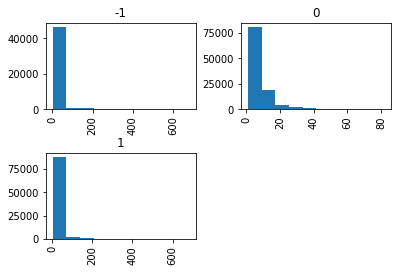

In [6]:
train_set.hist(column="words_count", by="label")

In [6]:
train_set_small = train_set[train_set['words_count'] <= 100]
train_set_small = train_set_small.dropna()

In [9]:
train_set_small.describe()

,label,length,words_count
count,244595.000000,244595.000000,244595.000000
mean,0.175372,45.843885,11.542738
std,0.726008,51.392357,12.190590
min,-1.000000,1.000000,1.000000
25%,0.000000,16.000000,4.000000
50%,0.000000,28.000000,7.000000
75%,1.000000,53.000000,13.000000
max,1.000000,464.000000,100.000000


In [7]:
from tensorflow.keras.preprocessing import text, sequence
from gensim.models import Word2Vec
import multiprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, callbacks, regularizers
from tensorflow.keras.layers import CuDNNGRU, Conv1D, MaxPooling1D, SpatialDropout1D, Embedding, Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import os

In [9]:
sentences = train_set_small['text'].apply(lambda x: str(x).split())

In [12]:
w2v = Word2Vec(sentences, min_count=1, size=300, iter=20, workers=multiprocessing.cpu_count(),sorted_vocab=1)

In [13]:
wv = w2v.wv
print(wv.most_similar("buồn"))
print("Vocab size: %d"%len(wv.vocab))
filename = 'word_embedding.txt'
wv.save_word2vec_format(filename, binary=False)

[('bùn', 0.49478358030319214), ('mệt', 0.44434282183647156), ('bực', 0.3779468238353729), ('đau', 0.363492488861084), ('tiếc', 0.3536754250526428), ('phiền', 0.3471372127532959), ('khóc', 0.3428797721862793), ('chán', 0.34006422758102417), ('bận', 0.3354771137237549), ('dzâyh', 0.3326527774333954)]
Vocab size: 33374


In [33]:
MAX_LEN = 100
VOCAB_SIZE = 33000

In [34]:
tokenizer = text.Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(train_set_small.text.astype(str))

In [35]:
X = tokenizer.texts_to_sequences(train_set_small.text.astype(str))
X = sequence.pad_sequences(X, maxlen=MAX_LEN)

In [36]:
test_set = test_set.dropna()

In [37]:
X_test = sequence.pad_sequences(tokenizer.texts_to_sequences(test_set.text.astype(str)), maxlen=MAX_LEN)

In [38]:
Y = train_set_small.label + 1
Y = to_categorical(Y,num_classes=3)

In [40]:
Y_test = test_set.label + 1
Y_test = Y_test.fillna(1)
Y_test_cate = to_categorical(Y_test,num_classes=3)

In [15]:
import tensorflow.keras.backend as K

def precision(y_true, y_pred): 
    """Precision metric. Only computes a batch-wise average of precision.  
-    Computes the precision, a metric for multi-label classification of 
-    how many selected items are relevant. 
-    """ 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) 
    precision = true_positives / (predicted_positives + K.epsilon()) 
    return precision 

def recall(y_true, y_pred): 
    """Recall metric. 
-    Only computes a batch-wise average of recall. 
-    Computes the recall, a metric for multi-label classification of 
-    how many relevant items are selected. 
-    """ 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) 
    recall = true_positives / (possible_positives + K.epsilon()) 
    return recall 

def fbeta_score(y_true, y_pred, beta=1): 

    """Computes the F score.  
-    The F score is the weighted harmonic mean of precision and recall. 
-    Here it is only computed as a batch-wise average, not globally. 
-    This is useful for multi-label classification, where input samples can be 
-    classified as sets of labels. By only using accuracy (precision) a model 
-    would achieve a perfect score by simply assigning every class to every 
-    input. In order to avoid this, a metric should penalize incorrect class 
-    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0) 
-    computes this, as a weighted mean of the proportion of correct class 
-    assignments vs. the proportion of incorrect class assignments.  
-    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning 
-    correct classes becomes more important, and with beta > 1 the metric is 
-    instead weighted towards penalizing incorrect class assignments. 
-    """ 
    if beta < 0: 
        raise ValueError('The lowest choosable beta is zero (only precision).') 

    # If there are no true positives, fix the F score at 0 like sklearn. 
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0: 

        return 0 
    p = precision(y_true, y_pred) 
    r = recall(y_true, y_pred) 
    bb = beta ** 2 
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon()) 
    return fbeta_score 

def fmeasure(y_true, y_pred): 
    """Computes the f-measure, the harmonic mean of precision and recall. 
    Here it is only computed as a batch-wise average, not globally. 
    """ 
    return fbeta_score(y_true, y_pred, beta=1) 

In [ ]:
from sklearn.metrics import f1_score

In [41]:
def create_model(dim=300, dropout_rate=0.2, conv_size=2, pool_size=2, units=100, embed=None, trainable=False, VOCABSIZE=VOCAB_SIZE, l2=0.001, max_len=MAX_LEN):
    model = Sequential()
    model.add(InputLayer(input_shape=(max_len,)))
    model.add(Embedding(VOCABSIZE, dim, input_length=max_len, weights=embed))
    model.add(CuDNNGRU(units, kernel_regularizer=regularizers.l2(l2)))
    model.add(Dense(3, activation='softmax', kernel_initializer='normal'))
    print(model.summary())
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=[fmeasure, precision, recall])
    return model

In [42]:
model = create_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          9900000   
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 100)               120600    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 10,020,903
Trainable params: 10,020,903
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
checkpoint_path = 'training_wo_pretrain/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

CP = callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
ES = callbacks.EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=2)

cplist = [CP, ES]

In [44]:
history = model.fit(X, Y, batch_size=256, epochs=20, validation_split=0.1, callbacks=cplist, verbose=2)

Train on 220135 samples, validate on 24460 samples
Epoch 1/20

Epoch 00001: val_loss improved from inf to 0.46831, saving model to training_wo_pretrain/cp.ckpt
220135/220135 - 23s - loss: 0.5403 - fmeasure: 0.7873 - precision: 0.8230 - recall: 0.7630 - val_loss: 0.4683 - val_fmeasure: 0.8202 - val_precision: 0.8412 - val_recall: 0.8003
Epoch 2/20

Epoch 00002: val_loss improved from 0.46831 to 0.42970, saving model to training_wo_pretrain/cp.ckpt
220135/220135 - 23s - loss: 0.3849 - fmeasure: 0.8581 - precision: 0.8724 - recall: 0.8443 - val_loss: 0.4297 - val_fmeasure: 0.8317 - val_precision: 0.8468 - val_recall: 0.8171
Epoch 3/20

Epoch 00003: val_loss improved from 0.42970 to 0.42334, saving model to training_wo_pretrain/cp.ckpt
220135/220135 - 23s - loss: 0.3446 - fmeasure: 0.8714 - precision: 0.8839 - recall: 0.8594 - val_loss: 0.4233 - val_fmeasure: 0.8305 - val_precision: 0.8455 - val_recall: 0.8159
Epoch 4/20

Epoch 00004: val_loss improved from 0.42334 to 0.41938, saving model

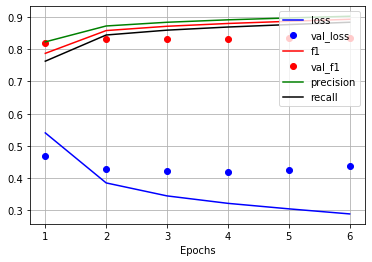

In [45]:
history_dict = history.history
#plot the metrics during training. 
epochs = range(1, len(history_dict['loss']) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, history_dict['loss'], 'b',label='loss')
plt.plot(epochs, history_dict['val_loss'], 'bo',label='val_loss')
plt.plot(epochs, history_dict['fmeasure'], 'r',label='f1')
plt.plot(epochs, history_dict['val_fmeasure'], 'ro',label='val_f1')
plt.plot(epochs, history_dict['precision'], 'g',label='precision')
plt.plot(epochs, history_dict['recall'], 'k',label='recall')

plt.xlabel('Epochs')
plt.grid()
plt.legend(loc=1)
plt.show()

In [46]:
predicted = model.predict_classes(X_test, batch_size=512)
print(classification_report(Y_test, predicted, digits=4))

              precision    recall  f1-score   support

         0.0     0.8124    0.7418    0.7755     24472
         1.0     0.8648    0.7586    0.8082     63707
         2.0     0.7241    0.8954    0.8007     42064

    accuracy                         0.7996    130243
   macro avg     0.8004    0.7986    0.7948    130243
weighted avg     0.8095    0.7996    0.7996    130243



In [47]:
model.load_weights(checkpoint_path)
predicted = model.predict_classes(X_test, batch_size=512)
print(classification_report(Y_test, predicted, digits=4))

              precision    recall  f1-score   support

         0.0     0.7766    0.7856    0.7811     24472
         1.0     0.8644    0.7633    0.8107     63707
         2.0     0.7468    0.8740    0.8054     42064

    accuracy                         0.8033    130243
   macro avg     0.7959    0.8077    0.7991    130243
weighted avg     0.8099    0.8033    0.8034    130243



In [28]:
from numpy import asarray, zeros

def load_embedding(filename):
    file = open(filename, 'r')
    lines = file.readlines()[1:]
    file.close()
    embedding = dict()
    for line in lines:
        parts = line.split()
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')
    return embedding
def get_weight_matrix(embedding, vocab, MAX_WORDS):
    weight_matrix = np.zeros((MAX_WORDS, 300))
    num_loss = 0
    for word, i in vocab.items():
        if i < MAX_WORDS:
            try:
                weight_matrix[i] = embedding[word]
            except:
                num_loss += 1
    print("Number of loss weight: {}".format(num_loss))
    return weight_matrix

In [29]:
raw_embedding = load_embedding(filename)
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index, VOCAB_SIZE)

Number of loss weight: 0


In [30]:
embedding_vectors.shape

(25000, 300)

In [31]:
model = create_model(embed=[embedding_vectors], trainable=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           7500000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 30, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 32)            19232     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 32)            0         
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 100)               40200     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 7,559,735
Trainable params: 7,559,735
Non-trainable params: 0
____________________________________________

In [32]:
checkpoint_path = 'training_w_pretrain/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

CP = callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

cplist = [CP]

In [33]:
history = model.fit(X, Y, batch_size=512, epochs=20, validation_split=0.4, callbacks=cplist)

Train on 131380 samples, validate on 87588 samples
Epoch 1/20
130560/131380 [============================>.] - ETA: 0s - loss: 0.4913 - fmeasure: 0.7771 - precision: 0.8148 - recall: 0.7565
Epoch 00001: val_fmeasure improved from -inf to 0.82667, saving model to training_w_pretrain/cp.ckpt
131380/131380 [==============================] - 9s 67us/sample - loss: 0.4906 - fmeasure: 0.7778 - precision: 0.8153 - recall: 0.7573 - val_loss: 0.4294 - val_fmeasure: 0.8267 - val_precision: 0.8435 - val_recall: 0.8105
Epoch 2/20
130816/131380 [============================>.] - ETA: 0s - loss: 0.3648 - fmeasure: 0.8560 - precision: 0.8718 - recall: 0.8409
Epoch 00002: val_fmeasure improved from 0.82667 to 0.83848, saving model to training_w_pretrain/cp.ckpt
131380/131380 [==============================] - 8s 64us/sample - loss: 0.3646 - fmeasure: 0.8562 - precision: 0.8720 - recall: 0.8411 - val_loss: 0.4006 - val_fmeasure: 0.8385 - val_precision: 0.8534 - val_recall: 0.8242
Epoch 3/20
130816/1313

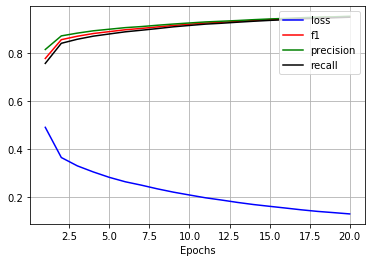

In [35]:
history_dict = history.history
#plot the metrics during training. 
epochs = range(1, len(history_dict['loss']) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, history_dict['loss'], 'b',label='loss')
plt.plot(epochs, history_dict['val_loss'], 'bo',label='val_loss')
plt.plot(epochs, history_dict['fmeasure'], 'r',label='f1')
plt.plot(epochs, history_dict['val_fmeasure'], 'ro',label='val_f1')
plt.plot(epochs, history_dict['precision'], 'g',label='precision')
plt.plot(epochs, history_dict['recall'], 'k',label='recall')

plt.xlabel('Epochs')
plt.grid()
plt.legend(loc=1)
plt.show()

In [36]:
model.load_weights(checkpoint_path)
predicted = model.predict_classes(X_test, batch_size=64)
print(classification_report(Y_test, predicted, digits=4))

              precision    recall  f1-score   support

         0.0     0.7703    0.7812    0.7757     24484
         1.0     0.8505    0.7881    0.8181     66200
         2.0     0.7567    0.8378    0.7952     42094

    accuracy                         0.8026    132778
   macro avg     0.7925    0.8024    0.7964    132778
weighted avg     0.8060    0.8026    0.8030    132778



In [20]:
import sentencepiece as spm

spm.SentencePieceTrainer.train('--input=data/train_sw.txt --model_prefix=m --vocab_size=1000000 model_type=bpe --bos_id=-1 --eos_id=-1 --pad_id=0 --unk_id=1')
sp = spm.SentencePieceProcessor()
sp.load('m.model')
X_sw = train_set_small['text'].apply(lambda x: sp.encode_as_ids(str(x)))
X_test_sw = test_set.dropna().text.apply(lambda x: sp.encode_as_ids(str(x)))

RuntimeError: Internal: /sentencepiece/src/trainer_interface.cc(498) [(trainer_spec_.vocab_size()) == (model_proto->pieces_size())] 

In [24]:
min_len = 10000
max_len = 0
mean = 0
for i in X_sw:
    leni = len(i)
    min_len = leni if leni < min_len else min_len
    max_len = leni if leni > max_len else max_len
    mean += leni
mean = mean / len(X_sw)
print("Min: {}\nMax: {}\nMean: {}".format(min_len,max_len,mean))

Min: 1
Max: 106
Mean: 11.672781536826182


In [25]:
X_sw_padded = sequence.pad_sequences(X_sw, maxlen=MAX_LEN)
X_test_sw_padded = sequence.pad_sequences(X_test_sw, maxlen=MAX_LEN)

In [26]:
model = create_model(VOCABSIZE=30000)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          9000000   
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 100)               120600    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 9,120,903
Trainable params: 9,120,903
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
checkpoint_path = 'training_w_pretrain/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

CP = callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
ES = callbacks.EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=2)

cplist = [CP, ES]

In [28]:
history = model.fit(X_sw_padded, Y, batch_size=256, epochs=20, validation_split=0.1, callbacks=cplist, verbose=2)

Train on 220135 samples, validate on 24460 samples
Epoch 1/20

Epoch 00001: val_loss improved from inf to 0.43565, saving model to training_w_pretrain/cp.ckpt
220135/220135 - 22s - loss: 0.4958 - fmeasure: 0.7987 - precision: 0.8285 - recall: 0.7774 - val_loss: 0.4357 - val_fmeasure: 0.8269 - val_precision: 0.8462 - val_recall: 0.8085
Epoch 2/20

Epoch 00002: val_loss improved from 0.43565 to 0.42939, saving model to training_w_pretrain/cp.ckpt
220135/220135 - 22s - loss: 0.3720 - fmeasure: 0.8580 - precision: 0.8720 - recall: 0.8446 - val_loss: 0.4294 - val_fmeasure: 0.8292 - val_precision: 0.8453 - val_recall: 0.8138
Epoch 3/20

Epoch 00003: val_loss improved from 0.42939 to 0.41614, saving model to training_w_pretrain/cp.ckpt
220135/220135 - 22s - loss: 0.3429 - fmeasure: 0.8699 - precision: 0.8824 - recall: 0.8578 - val_loss: 0.4161 - val_fmeasure: 0.8344 - val_precision: 0.8493 - val_recall: 0.8201
Epoch 4/20

Epoch 00004: val_loss did not improve from 0.41614
220135/220135 - 21s 

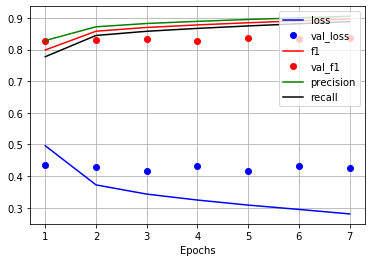

In [29]:
history_dict = history.history
#plot the metrics during training. 
epochs = range(1, len(history_dict['loss']) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, history_dict['loss'], 'b',label='loss')
plt.plot(epochs, history_dict['val_loss'], 'bo',label='val_loss')
plt.plot(epochs, history_dict['fmeasure'], 'r',label='f1')
plt.plot(epochs, history_dict['val_fmeasure'], 'ro',label='val_f1')
plt.plot(epochs, history_dict['precision'], 'g',label='precision')
plt.plot(epochs, history_dict['recall'], 'k',label='recall')

plt.xlabel('Epochs')
plt.grid()
plt.legend(loc=1)
plt.show()

In [30]:
predicted = model.predict_classes(X_test_sw_padded, batch_size=256)
print(classification_report(Y_test, predicted, digits=4))

              precision    recall  f1-score   support

         0.0     0.7454    0.7960    0.7699     24472
         1.0     0.8649    0.7524    0.8047     63707
         2.0     0.7456    0.8630    0.8000     42064

    accuracy                         0.7963    130243
   macro avg     0.7853    0.8038    0.7915    130243
weighted avg     0.8039    0.7963    0.7966    130243



In [31]:
model.load_weights(checkpoint_path)
predicted = model.predict_classes(X_test_sw_padded, batch_size=256)
print(classification_report(Y_test, predicted, digits=4))

              precision    recall  f1-score   support

         0.0     0.7843    0.7613    0.7726     24472
         1.0     0.8450    0.7870    0.8150     63707
         2.0     0.7592    0.8511    0.8025     42064

    accuracy                         0.8029    130243
   macro avg     0.7962    0.7998    0.7967    130243
weighted avg     0.8059    0.8029    0.8030    130243



In [18]:
sp.EncodeAsIds("▁<UNK>")

[31899, 1]